#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Load and print data

In [2]:
df = pd.read_csv("ParisHousing.csv")
df.head(3)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1


 #### Missing values

In [3]:
df.isna().sum().sum()

0


#### Split and standardize data

In [4]:
np.random.seed(1)
# split
df_train = df.sample(frac=.80)
df_dev   = df.drop(index=df_train.index)
print("Train examples: ", len(df_train), "\tDev examples: ", len(df_dev))

Train examples:  8000 	Dev examples:  2000


In [5]:
X_train, y_train  = df_train.iloc[:, :-1].values.T, df_train.iloc[:, -1].values.reshape(1, -1)
X_dev, y_dev      = df_dev.iloc[:, :-1].values.T, df_dev.iloc[:, -1].values.reshape(1, -1)

# mean and standard deviation
mu, sigma =  np.mean(X_train, axis=1, keepdims=True),  np.std(X_train, axis=1, keepdims=True)
# standardization
X_train =  (X_train - mu) / sigma
X_dev   = (X_dev - mu) / sigma


# dimensionality in trainning
print("\t\tDimentionality in training")
print(f"features dim: {X_train.shape} \tTarget dim: {y_train.shape}")

print("\n\t\tDimentionality in Dev")
print(f"features dim: {X_dev.shape} \tTarget dim: {y_dev.shape}")

		Dimentionality in training
features dim: (16, 8000) 	Target dim: (1, 8000)

		Dimentionality in Dev
features dim: (16, 2000) 	Target dim: (1, 2000)


 #### Activation functions

In [6]:
########################### activation functions ##############################

def ReLU(z):
    return np.maximum(0, z)

def dReLU(z):
    return np.where(z > 0, 1, 0)

def LeakyReLU(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def dLeakyReLU(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

def Tanh(z):
    return np.tanh(z)

def dTanh(z):
    return 1 - np.tanh(z)**2

def Sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dSigmoid(z):
    s = Sigmoid(z)
    return s * (1 - s)

def Softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def dSoftmax(z):
    s = Softmax(z)
    return s * (1 - s)

# dictionary of activation functions
dict_activation = {
    "relu": (ReLU, dReLU),
    "leakyrelu": (LeakyReLU, dLeakyReLU),
    "tanh": (Tanh, dTanh),
    "sigmoid": (Sigmoid, dSigmoid), 
    "Softmax": (Softmax, dSoftmax)
}


################################ loss functions ##############################
def binary_cross_entropy_loss(y, y_hat):
    m = y.shape[1]
    loss = -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / m
    return loss

def categorical_cross_entropy_loss(y, y_hat):
    m = y.shape[1]
    epsilon = 1e-10  # numrerical stability 
    loss = -np.sum(np.sum(np.multiply(y, np.log(y_hat + epsilon)), axis=0)) / m
    return loss

def mse_loss(y, y_hat):
    return np.mean(np.square(y_hat-y))

In [7]:
class Optimizer:
    def __init__(self, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentums = {}  # Store momentums for each parameter
        self.rmsprops = {}  # Store squared gradients for each parameter
        self.t = 0  # Time step counter for Adam

    def update_parameters_SGD(self, model, learning_rate=None):
        learning_rate = learning_rate or self.learning_rate
        for key in model.parameters.keys():
            model.parameters[key] -= learning_rate * model.gradients["d" + key]

    def update_parameters_SGD_with_momentum(self, model, learning_rate=None, momentum=None):
        learning_rate = learning_rate or self.learning_rate
        momentum = momentum or self.beta1

        for key in model.parameters.keys():
            if key not in self.momentums:
                self.momentums[key] = np.zeros_like(model.parameters[key])

            self.momentums[key] = momentum * self.momentums[key] + (1 - momentum) * model.gradients["d" + key]
            model.parameters[key] -= learning_rate * self.momentums[key]

    def update_parameters_RMSProp(self, model, learning_rate=None, beta2=None, epsilon=None):
        learning_rate = learning_rate or self.learning_rate
        beta2 = beta2 or self.beta2
        epsilon = epsilon or self.epsilon

        for key in model.parameters.keys():
            if key not in self.rmsprops:
                self.rmsprops[key] = np.zeros_like(model.parameters[key])

            self.rmsprops[key] = beta2 * self.rmsprops[key] + (1 - beta2) * np.square(model.gradients["d" + key])
            model.parameters[key] -= learning_rate * (model.gradients["d" + key] / np.sqrt(self.rmsprops[key] + epsilon))

    def update_parameters_Adam(self, model, learning_rate=None, beta1=None, beta2=None, epsilon=None):
        self.t += 1
        learning_rate = learning_rate or self.learning_rate
        for key in model.parameters.keys():
            if key not in self.momentums:
                self.momentums[key] = np.zeros_like(model.parameters[key])
            if key not in self.rmsprops:
                self.rmsprops[key] = np.zeros_like(model.parameters[key])

            self.momentums[key] = self.beta1 * self.momentums[key] + (1 - self.beta1) * model.gradients["d" + key]
            self.rmsprops[key] = self.beta2 * self.rmsprops[key] + (1 - self.beta2) * np.square(model.gradients["d" + key])
            
            mnt_corrected = self.momentums[key] / (1 - self.beta1 ** self.t)
            rms_corrected = self.rmsprops[key] / (1 - self.beta2 ** self.t)
            model.parameters[key] -= learning_rate * mnt_corrected / (np.sqrt(rms_corrected) + self.epsilon)


#### Neural network for a regression task

In [8]:
class NNRegressor:
    def __init__(self, layers_dims, weight_init="He", bias=True, activation_function=None):
        """
            Initializes the neural network with the specified parameters.
        """
        self.bias = bias
        self.total = 0
        self.memory = {}
        self.gradients = {}
        self.parameters = {}
        self.layers_dims = layers_dims
        self.number_of_layers = len(self.layers_dims)
        self.weight_init = weight_init
        self.initialize_weights() # initialization of parameters with "weight_init" method
        self.activation_function, self.activation_derivative = self.get_activation_functions(activation_function)

    

    def initialize_weights(self):
        """
        Initializes the weights and biases of the neural network.Three cases He, Xavier or Randomly with scale
        """
        #for layer, layer_dim in enumerate(tuple(zip(self.layers_dims, self.layers_dims[1:])), start=1):
        for l in range(1, self.number_of_layers):
            previous_layer_dim, current_layer_dim = self.layers_dims[l-1], self.layers_dims[l]#layer_dim

            if self.weight_init.lower() == "he":
                scale = np.sqrt(2 / previous_layer_dim)
            elif self.weight_init.lower() == "xavier":
                scale = np.sqrt(1 / previous_layer_dim)
            else:
                scale = .001

            self.parameters["W" + str(l)] = np.random.randn(current_layer_dim, previous_layer_dim) * scale
            if self.bias:
                self.parameters["B" + str(l)] = np.zeros((current_layer_dim, 1))

    

    
    def get_activation_functions(self, activation):
        """
        get the activation function and its derivative based on the provided activation name.
        """
        activation = activation.lower() if activation else "relu"
        
        if activation not in dict_activation:
            raise ValueError(f"Invalid activation function: {activation}. Supported values: {list(dict_activation.keys())}")
    
        return dict_activation[activation]


    
    def forward(self, x):
        """
            Performs the forward pass through the neural network.
            m is number of example
        """
        self.memory["A" + str(0)] = A_previous = x
        # Hidden(s) layer(s)
        for l in range(1, self.number_of_layers - 1):
            W = self.parameters["W" + str(l)]
            if self.bias:
                B = self.parameters["B" + str(l)]
                Z = np.dot(W, A_previous) + B
            else: 
                Z = np.dot(W, A_previous)
            self.memory["Z" + str(l)] = Z
            A_current = self.activation_function(Z)
            self.memory["A" + str(l)] = A_current
            A_previous = A_current
            
        # Output layer
        W = self.parameters["W" + str(self.number_of_layers - 1)]
        if self.bias: 
            B = self.parameters["B" + str(self.number_of_layers - 1)]
            Z = np.dot(W, A_previous) + B
        else:
            Z = np.dot(W, A_previous)
        self.memory["Z" + str(self.number_of_layers - 1)] = Z
        x = Z
        return x


    
    def backward(self, X, Y, Y_hat):
        """
            Performs the backward pass (backpropagation) through the neural network to compute gradients.
            Keys represent parameter names (e.g., 'dW1', 'dB2'), and values are the corresponding gradients.
        """
        m = X.shape[1]
        dZ = 2/m * (Y_hat - Y) # not activation function 
        
        # For output layer
        self.memory["dZ" + str(self.number_of_layers - 1)] = dZ
        A_previous = self.memory["A" + str(self.number_of_layers - 2)]                         
        self.gradients["dW" + str(self.number_of_layers - 1)] = np.dot(dZ, A_previous.T) / m    
        if self.bias:
            self.gradients["dB" + str(self.number_of_layers - 1)] = np.sum(dZ, axis=1, keepdims=True) / m

        # For Hidden(s) layer(s)
        for l in reversed(range(1, self.number_of_layers - 1)):
            W_next = self.parameters["W" + str(l + 1)]
            dZ_next = self.memory["dZ" + str(l + 1)]
            Z_current = self.memory["Z" + str(l)]
            A_previous = self.memory["A" + str(l - 1)]
            dZ_current = np.multiply(np.dot(W_next.T, dZ_next), np.vectorize(self.activation_derivative)(Z_current))
            self.gradients["dW" + str(l)] = np.dot(dZ_current, A_previous.T) / m 
            if self.bias:
                self.gradients["dB" + str(l)] = np.sum(dZ_current, axis=1, keepdims=True) / m
            self.memory["dZ" + str(l)] = dZ_current

        return self.gradients



    def total_parameters(self):
        """
        Calculates the total number of parameters in the neural network.
        """
        self.total = 0
        for i in range(1, self.number_of_layers):
            if self.bias:
                self.total += self.layers_dims[i] * (self.layers_dims[i - 1] + 1)
            else:
                self.total += self.layers_dims[i] * (self.layers_dims[i - 1])
        return self.total
        

    def predict(self, x):
        """
        Perform value predictions using the trained neural network.
       """
        A = x
        # Hidden layer(s)
        for l in range(1, self.number_of_layers - 1):
            W = self.parameters["W" + str(l)]
            if self.bias:
                B = self.parameters["B" + str(l)]
                x = self.activation_function(np.dot(W, x) + B)
            else:
                 x = self.activation_function(np.dot(W, x))
                
        # Output layer
        W = self.parameters["W" + str(self.number_of_layers - 1)]
        if self.bias:
            B = self.parameters["B" + str(self.number_of_layers - 1)]
            out = np.dot(W, x) + B
        else:
            out = np.dot(W, x) 
        return out




    def check_gradient(self):
        """
        Placeholder for a method that could be used to check gradients.
        """
        pass

    def __call__(self, x):
        """
        Makes the object callable, allowing for convenient use like a function.
        """
        return self.forward(x)

    def __repr__(self):
        """
        Returns a string representation of the neural network object.
        """
        layer_info = ""
        for i in range(1, self.number_of_layers - 1):
            layer_info += f"\n\tLayer {i}: Linear(in_dim={self.layers_dims[i-1]}, out_dim={self.layers_dims[i]}, bias={self.bias})\
            \n\tActivation function: {self.activation_function.__name__}()"

        return f"NN model with {self.number_of_layers} layers of which {self.number_of_layers - 2} hidden layer\
       \n\n\t(Input layer): (Layer 0 : (dim={self.layers_dims[0]})\
       \n\t(Hidden layers): ({layer_info})\
       \n\t(Output layer): (Layer {self.number_of_layers - 1} Linear(in_dim={self.layers_dims[-2]}, out_dim={self.layers_dims[-1]}, bias={self.bias})"

    def __str__(self):
        """
        Returns a string representation of the neural network object.
        """
        return self.__repr__()

#### Hyperparameters and instanciations

In [9]:
# hyperparameters
lr = .4
nb_iter  =  2000
output = 1
input_dim = 16
layers_dims = [input_dim, 512, output]

np.random.seed(6) # to have the same initial values ​​at runtime

# criterion  and optimizer
criterion = mse_loss
optim = Optimizer()

# model
model = NNRegressor(layers_dims, weight_init="Xavier", activation_function="tanh")
print(f"{model} \n\nNumber of parameters:  {model.total_parameters()/1e6} Million(s)")

# training and dev logs
train_loss, dev_loss = [], []

NN model with 3 layers of which 1 hidden layer       

	(Input layer): (Layer 0 : (dim=16)       
	(Hidden layers): (
	Layer 1: Linear(in_dim=16, out_dim=512, bias=True)            
	Activation function: Tanh())       
	(Output layer): (Layer 2 Linear(in_dim=512, out_dim=1, bias=True) 

Number of parameters:  0.009217 Million(s)


#### Training loop

In [10]:
for i in range(nb_iter):
    # step 1:  Forward
    y_hat = model(X_train)
    # step 2: Compute loss
    loss = np.sqrt(criterion(y_train, y_hat)) # rmse loss
    # step 3: Backward 
    grad = model.backward(X_train, y_train, y_hat)
    # step 4: update parameters
    optim.update_parameters_SGD_with_momentum(model, learning_rate=lr)
    # store loss 
    train_loss.append(loss)

    # Validation mode: use predict
    y_hat_dev = model.predict(X_dev).reshape(-1).tolist()
    loss_dev = np.sqrt(criterion(y_dev, y_hat_dev))
    dev_loss.append(loss_dev)
    if i % 200 == 0:
        print(f"iter: [{i}/{nb_iter}]  Train loss: {round(train_loss[-1])} | Dev loss: {round(dev_loss[-1])}")

iter: [0/2000]  Train loss: 5759240 | Dev loss: 5778393
iter: [200/2000]  Train loss: 354616 | Dev loss: 366701
iter: [400/2000]  Train loss: 182331 | Dev loss: 199470
iter: [600/2000]  Train loss: 135302 | Dev loss: 154342
iter: [800/2000]  Train loss: 119819 | Dev loss: 140174
iter: [1000/2000]  Train loss: 110941 | Dev loss: 131009
iter: [1200/2000]  Train loss: 104349 | Dev loss: 125172
iter: [1400/2000]  Train loss: 103513 | Dev loss: 123096
iter: [1600/2000]  Train loss: 99474 | Dev loss: 123352
iter: [1800/2000]  Train loss: 97333 | Dev loss: 119427


#### Visualize training logs

In [11]:
len(dev_loss)

2000

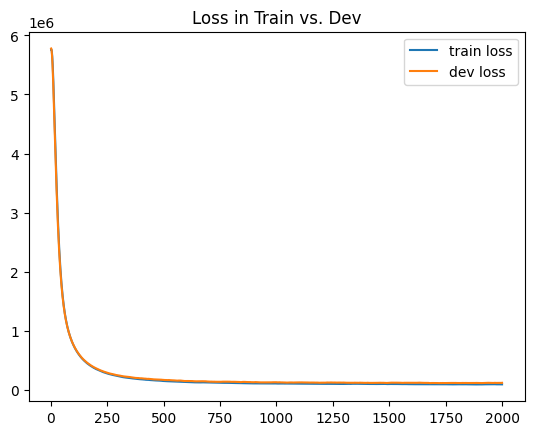

In [12]:
plt.plot(range(1,nb_iter+1), train_loss, label="train loss")
plt.plot(range(1,nb_iter+1), dev_loss, label="dev loss")
plt.title("Loss in Train vs. Dev")
plt.legend()
plt.show()

#### Prediction

In [13]:
df_dev["pred"] = model.predict(X_dev).reshape(-1).tolist()
df_dev.loc[:, ["price", "pred"]]

,price,pred
0,7559081.5,7.641318e+06
2,5574642.1,5.737763e+06
15,7607322.9,7.715967e+06
18,2604486.6,2.620140e+06
20,2888047.9,2.987163e+06
...,...,...
9974,601531.4,5.767606e+05
9983,8766795.5,8.832648e+06
9986,2701055.3,2.612520e+06
9989,9112369.0,9.188656e+06


#### Error distribution

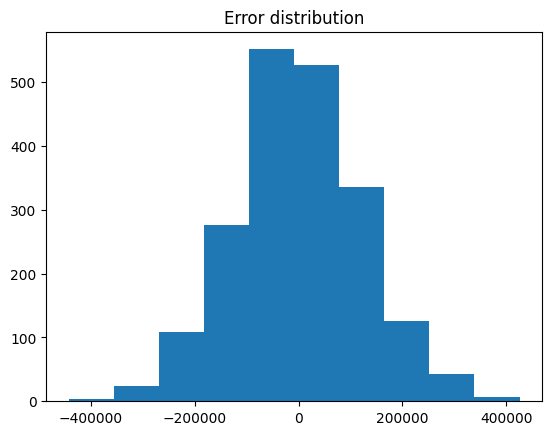

In [14]:
E = (df_dev["price"] - df_dev["pred"]).tolist()

plt.hist(E)
plt.title("Error distribution")
plt.show()

#### RMSE in dev

In [15]:
print(f"RMSE in dev: {int(np.sqrt(np.mean(np.array(E)**2)))}")

RMSE in dev: 122684
